JaeYoen Park 50194193

MTH 448

Due: 2023/04/23

# Text Classification with naive Bayes

## Introduction

These days, text classification is the fundamental technique in Natural Language Processing(NLP) that is essential to AI-chat such as Siri or Chat bot. It is a machine learning technique that assigns a set of predefined categories to open-ended text.[1] Text classification typically works based on machine learning techniques to analyze text data and learn pattern to make accurate predictions on new, unused data. From this project, we will be analyzing two different sources which are presidential debate transcript from web and movie reviews file by using naive Bayes inference. Our objective is to study how accuracy of Naive Bayes classifier improves by usage of list of stop words. 

## Background

### Naive Bayes

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.[2]
The idea of this equation is classify from one of the classified result $y$ by calculating the probability considering the conditions.
$$
p(y | (x_1, x_2, x_3, \dots, x_N)) \varpropto p(y) \times \prod^N_{k = 1} p(x_k | y)
$$

for $y \in \{\text{valuables to be judged}\}$.

In this project, We will be using $\log( P(y|x) )$ instead of $ P(y|x) $ to avoid underflow errors.

### Counter

Counter is essential library that is used to prepare for Text classification. As the data transformation of data frame contains classifying valuables and matching results, counter let classifying valuables to count the repetition of each words. Since the count is most important factor in classification to verify which matching result will most likely to be, it is required for preparation.

### Laplace Smoothing

Laplace Smoothing is a method that is used in multinomial Naive Bayes which prevents the zero probabilities during computation. It can be prevented by simply add 1 to counted data frame which 0 occurrence words to be 1. 

### Clean Strings

Cleaning strings are one of the important task before classification. As the text contains characters such as punctuations or other characters that may disturb the classifications, we must clean the texts before going through the Counter. 

### Stop words

Stop words are the words that may disturb the prediction accuracy. It is called stop words because it is commonly used regardless of classification. While this project focus on debate transcript and movie reviews, it means words that are not related to language habits or words that cannot be judged negative or positive.

Example of stop words are "are", "at", "from".

## Data Acquisition

### Import Necessary Libraries and data

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from collections import Counter
from zipfile import ZipFile
%pylab inline
from sklearn.model_selection import train_test_split
from scipy import stats as st
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Presidential transcript url from October 7th, 2020.
debate_url = 'https://www.debates.org/voter-education/debate-transcripts/vice-presidential-debate-at-the-university-of-utah-in-salt-lake-city-utah/'

In [3]:
# Read movie reviews
movies = pd.read_csv("movie_reviews.zip")
movies[:3]

review sentiment
0  This film is absolutely awful, but nevertheles...  negative
1  Well since seeing part's 1 through 3 I can hon...  negative
2  I got to see this film at a preview and was da...  positive

In [4]:
# Read stop words as a list
with open('stopwords.txt') as f:
    stops = f.read()
stops = stops.split(',')

## Data transformation

In [5]:
# Function to clean strings that aren't word.
def clean_string(string):    
    bad_strings = ['<br', '/', '>', ';', ',', '\\' ,'.','@','~','#','$','%','^','&','*','(' , ')','+','=','"',':','`','<','>','?','!','[',']','1','2','3','4','5','6','7','8','9','0','\n','--','[applause]','[inaudible]','[laughter]','[crosstalk]']
    for baddy in bad_strings:
        string = string.replace(baddy,'')
    string = string.replace('-',' ').replace('  ',' ')
    return string

### Presidential Debate Transcript 

Transform Text data from Web by scraping the necessary information and turn into data frame.
From source codes, debate transcripts are contained in each ptags. We acquire the certain range of ptags where actual debate is processed. While each transcript is formed by `Name: transcript`, we append each Name and transcript to list then turn into data frame.

With data frame, we divide them into certain percentage as training data and testing data. In this project, we will be testing 20% of total data.

After the process of cleaning strings and counting the words of training data, we create 2 separate data frame which are `Stop words dropped data as "wc_s"` and `original data as "wc"`.

In [6]:
# Using Beautiful Soup to scrape texts from website. Append Name and Transcript to the list then create a data frame.
debate = requests.get(debate_url).text
debate = BeautifulSoup(debate)
Name =[]
Transcript =[]

ptags = debate.find_all('p') # Find all <p> tags
p = ptags[4:-1]

for i in range(len(p)):
    
    if p[i].findAll('b') != []: # Find location of name, transcript
        name = p[i].findAll('b')[0].text.strip(':') # Find all the speakers
        transcript = p[i].find('b').nextSibling.get_text().strip('\xa0') # Find all the transcript strings
        
        Name.append(name)
        Transcript.append(transcript)
        
    if p[i].findAll('b') == []:
        transcript += p[i].get_text()
 
        Transcript[i-1] = transcript
    
ts = pd.DataFrame()
ts['Name'] = Name
ts['Transcript'] = Transcript
ts[:3]

Name                                         Transcript
0   PAGE  Good evening. From the University of Utah in S...
1  PENCE                                         Thank you.
2   PAGE  Senator Harris and Vice President Pence thank ...

In [7]:
ts['Name'].unique() # 3 Names from transcript

array(['PAGE', 'PENCE', 'HARRIS'], dtype=object)

In [8]:
# Divide the data frame by certain percentage as 80% training and 20% testing.
# Count the words after cleaning the strings
counter_page = Counter([])
counter_pence = Counter([])
counter_harris = Counter([])

X_train1, X_test1, y_train1, y_test1 = train_test_split(ts['Transcript'], 
                                                    ts['Name'], 
                                                    test_size=0.2, 
                                                    random_state=1) # sklearn library that split 20% as testing.
n = len(X_train1)
for i in tqdm(range(len(X_train1))): # Count words thorugh all training data 
    words = ts.loc[i,'Transcript'].lower()
    words = clean_string(words)   # Clean string 
    words = words.split(' ')
    
    if ts.loc[i,'Name'] == "PAGE":
        counter_page += Counter(words) #Count to PAGE column
    if ts.loc[i,'Name'] == "PENCE":
        counter_pence += Counter(words) #Count to PENCE column
    else:
        counter_harris += Counter(words) #Count to HARRIS column

100%|██████████████████████████████████████| 195/195 [00:00<00:00, 11437.73it/s]


In [9]:
# Convert the Counter to data frame as well as number types and filling n/a
d1 = {"PAGE":counter_page,"PENCE":counter_pence,"HARRIS":counter_harris}
wc = pd.DataFrame(d1)
wc = wc.fillna(0)
wc.PAGE = wc.PAGE.astype(int)
wc.PENCE = wc.PENCE.astype(int)
wc.HARRIS = wc.HARRIS.astype(int)
wc[:5]

PAGE  PENCE  HARRIS
good           2      0       4
evening        1      0       1
from           5     13      11
the          112    323     319
university     1      1       2

In [10]:
# Create another data frame which stop words are dropped then apply laplace smoothing.
wc_s = wc.drop(stops, errors='ignore')
wc_s = wc_s + 1
wc_s[:4]

PAGE  PENCE  HARRIS
good           3      1       5
evening        2      1       2
university     2      2       3
utah           2      2       2

In [11]:
# Apply laplace smoothing to original data frame.
wc = wc + 1

### Movie reviews

With movie reviews read from csv files into data frame, divide the data frame into training data and testing data. In this project, we will be testing 20% of total data.

After the process of cleaning strings and counting the words of training data, we create 2 separate data frame which are `Stop words dropped data as "wc2_s"` and `original data as "wc2"`.

In [12]:
# Divide the data frame by certain percentage as 80% training and 20% testing.
# Count the words after cleaning the strings
counter_pos = Counter([])
counter_neg = Counter([])

X_train2, X_test2, y_train2, y_test2 = train_test_split(movies['review'], 
                                                    movies['sentiment'], 
                                                    test_size=0.2, 
                                                    random_state=1) # sklearn library that split 20% as testing.

n = len(X_train2)
for i in tqdm(range(len(X_train2))): # Count words thorugh all training data 
    words = movies.loc[i,'review'].lower()
    words = clean_string(words)    # Clean string
    words = words.split(' ')
    
    if movies.loc[i,'sentiment'] == "positive":
        counter_pos += Counter(words) #Count to positive column
    else:
        counter_neg += Counter(words) # Count to negative column


100%|████████████████████████████████████| 20000/20000 [00:31<00:00, 643.16it/s]


In [13]:
# Convert the Counter to data frame as well as number types and filling n/a
d = {"Negative":counter_neg,"Positive":counter_pos}
wc2 = pd.DataFrame(d)
wc2 = wc2.fillna(0)
wc2.Negative = wc2.Negative.astype(int)
wc2.Positive = wc2.Positive.astype(int)
wc2[:5]

Negative  Positive
this           32814     27747
film           14877     16014
is             40412     45299
absolutely       683       511
awful           1213       126

In [14]:
# Create another data frame which stop words are dropped then apply laplace smoothing.
wc2_s = wc2.drop(stops, errors='ignore')
wc2_s = wc2_s + 1
wc2_s[:4]

Negative  Positive
film             14878     16015
absolutely         684       512
awful             1214       127
nevertheless        58       121

In [15]:
# Apply laplace smoothing to original data frame.
wc2 = wc2 + 1

## How do stop words effect the prediction accuracy?

While predicting the results by going over each words from text, there exist multiple factors that could effect the accuracy in prediction. In this project, we will observe the condition when absence of stop words. 

In this stage we will apply the function that compute the prediction based on Naive Bayes method. Each string we will go through the process of cleaning, split as word, compute, append prediction into list. With Prediction list and actual list, create a confusion matrix to visualize the result and check the accuracy.

### Presidential Transcript (Stop words included)

In [16]:
# Function that predict the speaker by Naive Bayes inference
def trs1_probs(X_text1):
    value_page_lst = []
    value_pence_lst = []
    value_harris_lst = []

    words = clean_string(X_text1).lower().split(' ') #Clean string
    for word in words:
        try:
            p = wc.loc[word]/wc.sum() # The probability P[x|y] for either y=PAGE or y=PENCE or y=HARRIS.
            value_page_lst.append(p["PAGE"])
            value_pence_lst.append(p["PENCE"])
            value_harris_lst.append(p["HARRIS"])
        except:
            None

    tot = np.array(wc.sum()).sum() # Total number of words regardless of speaker.
    prod = np.ones(3) # There are three states, PAGE, PENCE, HARRIS.  We initialize with 1.
    prod[0] = wc['PAGE'].sum()/(tot) # The probability P[y=PAGE] that a random word is spoken by PAGE.
    prod[1] = wc['PENCE'].sum()/(tot) # The probability P[y=PENCE] that a random word is spoken by PENCE.
    prod[2] = wc['HARRIS'].sum()/(tot) # The probability P[y=HARRIS] that a random word is spoken by HARRIS.
    
    prod = np.log10(prod) # We take the log, since we are doing log likelihood.
    
    prod[0] += np.log10(value_page_lst).sum() # Log likelihood means we add logs of the probability.
    prod[1] += np.log10(value_pence_lst).sum()
    prod[2] += np.log10(value_harris_lst).sum()

    return ['PAGE','PENCE','HARRIS'][np.argmax(prod)] # return the speaker with highest probability.

In [17]:
# Apply the above function to predict all the testing data
n = len(X_test1)
prediction =[]
actual =[]
for i in range(n):
    prediction.append(trs1_probs(X_test1.iloc[i]))
    actual.append(y_test1.iloc[i])
#prediction, actual

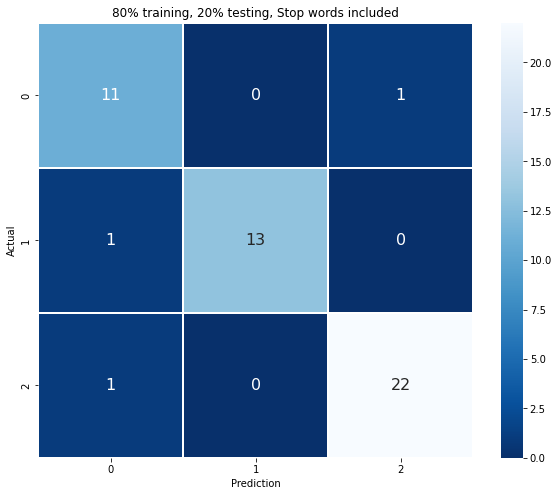

In [18]:
# Visualize confusion matrix as heatmap
y_true= actual # Array of real labels
y_pred= prediction # Array of predicted labels
c =confusion_matrix(y_true, y_pred) # Confusion matrix
plt.figure(figsize=(10, 8))

sns.heatmap(c, 
            annot=True,
            annot_kws = {"fontsize": 16},
            cbar=True,
            linewidth=2,
            square=True,
            cmap="Blues_r"
            
)
plt.title("80% training, 20% testing, Stop words included")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [19]:
accuracy = (c[0,0]+c[1,1]+c[2,2]) / len(prediction) * 100
print("The accuracy of prediction in debate(stop words included) was "+ str(accuracy)+"%")

The accuracy of prediction in debate(stop words included) was 93.87755102040816%


### Presidential Transcript (Stop words not included)

In [20]:
def trs_probs(X_text1):
    value_page_lst = []
    value_pence_lst = []
    value_harris_lst = []

    words = clean_string(X_text1).lower().split(' ')
    for word in words:
        if word in stops: # We want to make sure we're not using a stop word.
            None
        else:
            try:
                p = wc_s.loc[word]/wc_s.sum() # The probability P[x|y] for either y=PAGE or y=PENCE or y=HARRIS.
                value_page_lst.append(p["PAGE"])
                value_pence_lst.append(p["PENCE"])
                value_harris_lst.append(p["HARRIS"])
                
            except:
                None
  
    tot = np.array(wc_s.sum()).sum() # Total number of words regardless of speaker.
    prod = np.ones(3) # There are three states, PAGE, PENCE, HARRIS.  We initialize with 1.
    prod[0] = wc_s['PAGE'].sum()/(tot) # The probability P[y=PAGE] that a random word is spoken by PAGE.
    prod[1] = wc_s['PENCE'].sum()/(tot) # The probability P[y=PENCE] that a random word is spoken by PENCE.
    prod[2] = wc_s['HARRIS'].sum()/(tot) # The probability P[y=HARRIS] that a random word is spoken by HARRIS.
    
    prod = np.log10(prod) # We take the log, since we are doing log likelihood.
    
    prod[0] += np.log10(value_page_lst).sum() # Log likelihood means we add logs of the probability.
    prod[1] += np.log10(value_pence_lst).sum()
    prod[2] += np.log10(value_harris_lst).sum()

    return ['PAGE','PENCE','HARRIS'][np.argmax(prod)] # return the speaker with highest probability.

In [21]:
# Apply the above function to predict all the testing data
n = len(X_test1)
prediction =[]
actual =[]
for i in range(n):
    prediction.append(trs_probs(X_test1.iloc[i]))
    actual.append(y_test1.iloc[i])
#prediction, actual

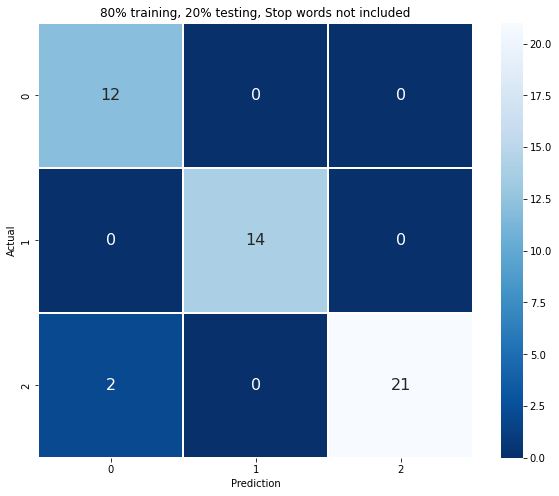

In [22]:
# Visualize confusion matrix as heatmap
y_true= actual # Array of real labels
y_pred= prediction # Array of predicted labels
c =confusion_matrix(y_true, y_pred) # Confusion matrix

plt.figure(figsize=(10, 8))

sns.heatmap(c, 
            annot=True,
            annot_kws = {"fontsize": 16},
            cbar=True,
            linewidth=2,
            square=True,
            cmap="Blues_r"
            
)
plt.title("80% training, 20% testing, Stop words not included")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [23]:
accuracy = (c[0,0]+c[1,1]+c[2,2]) / len(prediction) * 100
print("The accuracy of prediction in debate(stop words excluded) was "+ str(accuracy)+"%")

The accuracy of prediction in debate(stop words excluded) was 95.91836734693877%


### Movie reviews (Stop words included)

In [24]:
# Function that predict the tendency of movie review by Naive Bayes inference
def rev1_probs(X_text2):
    value_pos_lst = []
    value_neg_lst = []

    words = clean_string(X_text2).lower().split(' ') # Clean string
    for word in words:
        try:
            p = wc2.loc[word]/wc2.sum() # The probability P[x|y] for either y=negative or y=positive.
            value_pos_lst.append(p["Positive"])
            value_neg_lst.append(p["Negative"])
        except:
            None
                    
    tot = np.array(wc2.sum()).sum() # Total number of words regardless of positive or negative.
    prod = np.ones(2) # There are two states, positive or negative.  We initialize with 1.
    prod[0] = wc2['Negative'].sum()/(tot) #  The probability that a random word is negative.
    prod[1] = wc2['Positive'].sum()/(tot) #  The probability that a random word is positive.
    prod = np.log10(prod) # We take the log, since we are doing log likelihood.
    
    prod[0] += np.log10(value_neg_lst).sum() # Log likelihood means we add logs of the probability.
    prod[1] += np.log10(value_pos_lst).sum()

    return ['negative','positive'][np.argmax(prod)] # return the tendency of the review with highest probability.

In [25]:
# Apply the above function to predict all the testing data
n = len(X_test2)
prediction =[]
actual =[]
for i in range(n):
    prediction.append(rev1_probs(X_test2.iloc[i]))
    actual.append(y_test2.iloc[i])
#prediction, actual

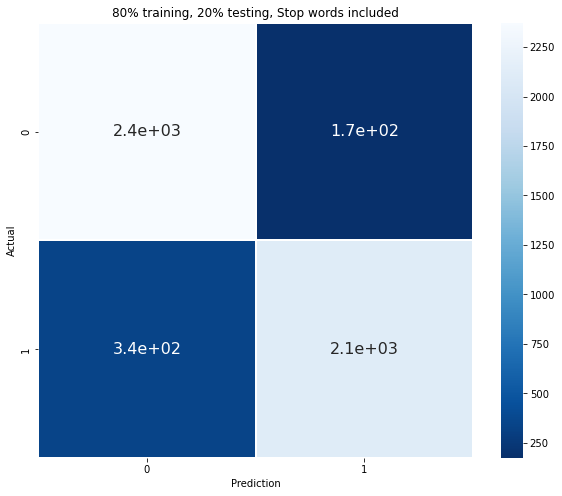

In [26]:
# Visualize confusion matrix as heatmap
y_true= actual # Array of real labels
y_pred= prediction # Array of predicted labels
c =confusion_matrix(y_true, y_pred) # Confusion matrix
plt.figure(figsize=(10, 8))

sns.heatmap(c, 
            annot=True,
            annot_kws = {"fontsize": 16},
            cbar=True,
            linewidth=2,
            square=True,
            cmap="Blues_r"
            
)
plt.title("80% training, 20% testing, Stop words included")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [27]:
accuracy = (c[0,0]+c[1,1]) / len(prediction) * 100
print("The accuracy of prediction in movie reviews(stop words included) was "+ str(accuracy)+"%")

The accuracy of prediction in movie reviews(stop words included) was 89.66%


### Movie reviews (Stop words not included)

In [28]:
# Function that predict the tendency of movie review by Naive Bayes inference
def rev_probs(X_text2):
    value_pos_lst = []
    value_neg_lst = []

    words = clean_string(X_text2).lower().split(' ') # Clean string
    for word in words:
        if word in stops: # We want to make sure we're not using a stop word.
            None
        else:
            try:
                p = wc2_s.loc[word]/wc2_s.sum() # The probability P[x|y] for either y=negative or y=positive.
                value_pos_lst.append(p["Positive"])
                value_neg_lst.append(p["Negative"])
            except:
                None

    tot = np.array(wc2_s.sum()).sum() # Total number of words regardless of positive or negative.
    prod = np.ones(2) # There are two states, positive or negative.  We initialize with 1.
    prod[0] = wc2_s['Negative'].sum()/(tot) #  The probability that a random word is negative.
    prod[1] = wc2_s['Positive'].sum()/(tot) #  The probability that a random word is positive.
    prod = np.log10(prod) # We take the log, since we are doing log likelihood.
    
    prod[0] += np.log10(value_neg_lst).sum() # Log likelihood means we add logs of the probability.
    prod[1] += np.log10(value_pos_lst).sum()

    return ['negative','positive'][np.argmax(prod)] # return the tendency of the review with highest probability.

In [29]:
# Apply the above function to predict all the testing data 
n = len(X_test2)
prediction =[]
actual =[]
for i in range(n):
    prediction.append(rev_probs(X_test2.iloc[i]))
    actual.append(y_test2.iloc[i])
#prediction, actual

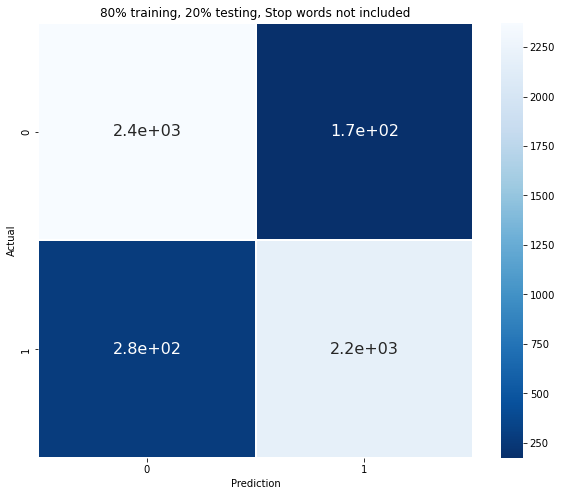

In [30]:
# Visualize confusion matrix as heatmap
y_true= actual # Array of real labels
y_pred= prediction # Array of predicted labels
c =confusion_matrix(y_true, y_pred) # Confusion matrix
plt.figure(figsize=(10, 8))

sns.heatmap(c, 
            annot=True,
            annot_kws = {"fontsize": 16},
            cbar=True,
            linewidth=2,
            square=True,
            cmap="Blues_r"
            
)
plt.title("80% training, 20% testing, Stop words not included")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [31]:
accuracy = (c[0,0]+c[1,1]) / len(prediction)* 100
print("The accuracy of prediction in movie reviews(stop words excluded) was "+ str(accuracy)+"%")

The accuracy of prediction in movie reviews(stop words excluded) was 90.96%


## Conclusion

Text classification is the fundamental technique in Natural Language Processing(NLP) that is essential to AI-chat such as Siri or Chat bot. In this project, we have studied the mechanism of text classification using Naive Bayes inference. From two source of data; presidential debate transcript from web and movie reviews from csv file, we predicted the speaker of debate and positive or negative of reviews. To be able to classify the text, Data Acquisition and data transformation is necessary task which the classifier could intake precise text. After the preparation of data frame with counted words, we applied Naive Bayes inference to predict the result. 

The key point of this classification is to analyze frequently used words as individual language habits, predict who is most likely to use the word through the test, or determine that the use of the word is mainly used in negative or positive situations, and through the test, each word is analyzed to predict whether it is negative or positive.

However, there are words in the sentence that are not helpful for analysis. In the case of this project, it means words that are not related to language habits or words that cannot be judged negative or positive, and we call them stop words.

The same amount of testing was applied to each debate and movie data, and analysis was performed considering only the presence or absence of stop words. As a result, both data showed a high prediction rate when the stop word was excluded. As a result of testing 20% of the total data, the prediction rate increased by about 2% for discussion data and about 1% for movie data. Hence, we were able to find out that text analyzers have multiple factors that can affect prediction rates, and stop words are one of them.

## Reference

1.Text classification: What it is and why it matters. MonkeyLearn. (n.d.). Retrieved April 23, 2023, from https://monkeylearn.com/textclassification/#:~:text=Tutorial-,What%20is%20Text%20Classification%3F,and%20all%20over%20the%20web.[1]

2.1.9. naive Bayes. scikit. (n.d.). Retrieved April 23, 2023, from https://scikitlearn.org/stable/modules/naive_bayes.html#:~:text=Naive%20Bayes%20methods%20are%20a,value%20of%20the%20class%20variable [2]

3.October 07, 2020 Vice presidential debate transcript. CPD: October 07, 2020 Vice Presidential Debate Transcript. (n.d.). Retrieved April 23, 2023, from https://www.debates.org/voter-education/debate-transcripts/vice-presidential-debate-at-the-university-of-utah-in-salt-lake-city-utah/ 